In [1]:
from pydantic import BaseModel, ConfigDict, Field, ValidationError, model_validator
import json
import yaml
from pathlib import Path
from typing import Protocol, runtime_checkable, Tuple, Optional, Any
from functools import cached_property
import hashlib
from datetime import datetime
import pandas as pd
import numpy as np
import narwhals as nw
import time
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)
from CovarianceCleaner import (
    CleanerType, 
    create_covariance_cleaner, 
    MPCleanerConfig, 
    RIECleanerConfig
)

# Configurations

In [2]:
# =============================
# Pydantic Configuration Models
# =============================

class StrategyConfig(BaseModel):
    """
    A strategy config with settings related to risk appetite, vol targeting, leverage limits.
    """
    model_config = ConfigDict(frozen=True, extra='forbid')

    target_volatility: float = Field(default=0.10, gt=0.0, le=0.50, description="Annualized target volatility")
    vol_lookback: int = Field(default=22, gt=1, description="Lookback window size for target volatility")
    use_ewma: bool = Field(default=True, description="Use of EWMA (True) or plain realised volatility (False) for target volatility")
    ewma_vol_decay: float = Field(default=0.90, gt=0.0, lt=1.0, description="Decay parameter for EWMA volatility - faster adaptation")
    max_leverage: float = Field(default=3.0, gt=1.0, description="Maximum leverage from vol targeting")
    min_leverage: float = Field(default=0.02, gt=0.0, description="Minimum leverage from vol targeting - lower bound for flexibility"
    )
    max_gross_leverage: float = Field(default=2.0, gt=0.0, description="Hard cap on gross exposure")
    max_position_size: float = Field(default=0.05, gt=0.0, le=0.50, description="Max absolute weight per stock")

    # Cross-field validation
    def model_post_init(self, __context) -> None:
        if self.min_leverage > self.max_leverage:
            raise ValueError("min_leverage must be <= max_leverage")
            
class FactorConfig(BaseModel):
    """
    A factor config with settings related to the factor modelling.
    """
    model_config = ConfigDict(frozen=True, extra='forbid')

    correlation_lookback: int = Field(default=252, ge=60, description="Lookback days for correlation/PCA")
    use_ewma_corr: bool = Field(default=True, description="Use EWMA correlation for factor model")
    ewma_corr_decay: float = Field(default=0.94, gt=0.0, lt=1.0, description="Decay for EWMA correlation")
    cleaner_type: CleanerType = Field(
        default=CleanerType.RIE,
        description="Covariance denoising method. Use enum for easy extension."
    )
    cleaner_config: dict[str, Any] = Field(
        default_factory=dict,
        description=(
            "Cleaner-specific parameters (e.g. grid_size/bandwidth for RIE, "
            "threshold_multiplier for MP). Passed as **kwargs to create_covariance_cleaner()."
        )
    )

    @model_validator(mode='after')
    def validate_cleaner_config(self) -> 'FactorConfig':
        cfg = self.cleaner_config or {}
        if self.cleaner_type == CleanerType.MP:
            MPCleanerConfig(**cfg)
        elif self.cleaner_type == CleanerType.RIE:
            RIECleanerConfig(**cfg)
        # IDENTITY needs no config
        return self

class SignalConfig(BaseModel):
    """
    A signal config with settings handling mean reversion threshold, long/short open/close thresholds, sizing.
    """
    model_config = ConfigDict(frozen=True, extra='forbid')

    kappa_threshold: float = Field(default=2.8, gt=0.0, description="Mean reversion threshold")
    s_score_open_long: float = Field(default=1.9, gt=0.0, description="s-score threshold for opening a long position")
    s_score_open_short: float = Field(default=1.9, gt=0.0, description="s-score threshold for opening a short position")
    s_score_close_long: float = Field(default=0.75, gt=0.0, description="s-score threshold for closing a long position")
    s_score_close_short: float = Field(default=0.75, gt=0.0, description="s-score threshold for closing a short position")
    prop_scaling_factor: float = Field(default=1.0, gt=0.0, description="Scaling for dynamic proportional sizing")
    prop_min_size: float = Field(default=0.3, ge=0.0, le=1.0, description="Lower bound for the proportional size")
    prop_max_size: float = Field(default=1.8, ge=0.0, description="Upper bound for the proportional size")

    # Cross-field validation
    def model_post_init(self, __context) -> None:
        if self.prop_min_size > self.prop_max_size:
            raise ValueError("prop_min_size must be <= prop_max_size")
        if self.s_score_close_long > self.s_score_open_long:
            raise ValueError("Close threshold must be <= open threshold for long positions")
        if self.s_score_close_short > self.s_score_open_short:  # Added check for short
            raise ValueError("Close threshold must be <= open threshold for short positions")

class RootConfig(BaseModel):
    """
    A root config to load everything from one file.
    """
    model_config = ConfigDict(frozen=True, extra='forbid')

    strategy: StrategyConfig = StrategyConfig()
    factor: FactorConfig = FactorConfig()
    signal: SignalConfig = SignalConfig()

    @cached_property
    def config_hash(self) -> str:
        """Deterministic 16-character hash of the full config (including defaults)."""
        # model_dump(mode="json") + sort_keys guarantees identical string every time
        data = self.model_dump(mode="json", exclude_unset=False)
        json_str = json.dumps(
            data,
            sort_keys=True,
            separators=(",", ":"),   # compact, no whitespace
            default=str
        )
        return hashlib.sha256(json_str.encode("utf-8")).hexdigest()
        
# ==================
# Loading from JSON
# ==================

def load_config_from_json(file_path: str | Path) -> RootConfig:
    """
    Load the full configuration from a single JSON file.
    
    Example JSON structure (config.json):
    {
        "strategy": {
            "target_volatility": 0.12,
            "max_leverage": 4.0
        },
        "factor": {
            "correlation_lookback": 252
        },
        "signal": {
            "kappa_threshold": 3.0
        }
    }
    """
    path = Path(file_path)
    if not path.exists():
        raise FileNotFoundError(f"Config file not found: {path}")
    
    try:
        data = json.loads(path.read_text())
        return RootConfig.model_validate(data)
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON in config file: {e}")
    except ValidationError as e:
        raise ValueError(f"Config validation failed: {e.errors()}")

# ==================
# Loading from YAML
# ==================
def load_config_from_yaml(file_path: str | Path) -> RootConfig:
    path = Path(file_path)
    if not path.exists():
        raise FileNotFoundError(f"Config file not found: {path}")
    
    try:
        data = yaml.safe_load(path.read_text())
        return RootConfig.model_validate(data)
    except yaml.YAMLError as e:
        raise ValueError(f"Invalid YAML: {e}")
    except ValidationError as e:
        raise ValueError(f"Config validation failed: {e.errors()}")

In [3]:
# Example usage
# config = load_config_from_json("config.json")
config = load_config_from_yaml("config.yaml")
strat_cfg = config.strategy
factor_cfg = config.factor
signal_cfg = config.signal

In [4]:
print(f"Strategy Config: {strat_cfg}")
print(f"Factor Config: {factor_cfg}")
print(f"Signal Config: {signal_cfg}")

Strategy Config: target_volatility=0.2 vol_lookback=42 use_ewma=True ewma_vol_decay=0.95 max_leverage=7.0 min_leverage=0.05 max_gross_leverage=5.0 max_position_size=0.3
Factor Config: correlation_lookback=256 use_ewma_corr=True ewma_corr_decay=0.95 cleaner_type=<CleanerType.RIE: 'rie'> cleaner_config={}
Signal Config: kappa_threshold=2.2 s_score_open_long=1.65 s_score_open_short=1.65 s_score_close_long=0.5 s_score_close_short=0.75 prop_scaling_factor=1.0 prop_min_size=0.25 prop_max_size=3.0


In [5]:
print(f"Hash RootConfig: {config.config_hash}")

Hash RootConfig: 82c0afa4fd860b84a86b9512052796fe6aa88b0fef8b92d4e2f8e39d5dc5c530


# Interfaces

In [6]:
# ===================
# Protocol Interfaces
# ===================
#
# Protocols use narwhals for DataFrame/Series operations to support both pandas and polars 
# 

@runtime_checkable
class FactorModel(Protocol):
    """Protocol for factor decomposition models."""

    def fit(self, returns: nw.DataFrame) -> None:
        """
        Fit the factor model on historical returns.
        
        Parameters
        ----------
        returns : nw.DataFrame
            Historical asset returns (rows = dates, columns = assets).
        """
        ...

    def get_factor_returns(self, returns: nw.DataFrame) -> nw.DataFrame:
        """
        Compute factor portfolio returns for a window of data.
        
        Returns
        -------
        nw.DataFrame
            Factor returns (rows = dates, columns = factors).
        """
        ...

    def get_factor_loadings(self, returns: nw.DataFrame) -> nw.DataFrame:
        """
        Compute factor exposures (betas) for each asset.
        
        Returns
        -------
        nw.DataFrame
            Loadings matrix (rows = assets, columns = factors) or similar.
        """
        ...


@runtime_checkable
class SignalGenerator(Protocol):
    """Protocol for generating mispricing signals from residuals."""

    def generate(self, residuals: nw.DataFrame) -> nw.Series:
        """
        Generate s-scores (or equivalent) from idiosyncratic residuals.
        
        Parameters
        ----------
        residuals : nw.DataFrame
            Asset-specific residuals after factor hedging (rows = dates, columns = assets).
        
        Returns
        -------
        nw.Series
            Latest signal per asset (index = assets).
        """
        ...


@runtime_checkable
class PositionSizer(Protocol):
    """Protocol for converting signals + loadings into hedged positions."""

    def size_positions(
        self,
        signals: nw.Series,
        loadings: nw.DataFrame,
        current_positions: nw.DataFrame,
    ) -> nw.DataFrame:
        """
        Compute new dollar-neutral positions including factor hedges.
        
        Parameters
        ----------
        signals : nw.Series
            Current mispricing signals (per asset).
        loadings : nw.DataFrame
            Factor exposures for hedging.
        current_positions : nw.DataFrame
            Existing positions (for entry/exit logic).
        
        Returns
        -------
        nw.DataFrame
            Updated positions (typically single row or full history).
        """
        ...


@runtime_checkable
class RiskOverlay(Protocol):
    """Protocol for post-processing positions with risk controls (e.g., vol targeting)."""

    def apply(
        self,
        portfolio_returns: nw.Series,
        positions: nw.DataFrame,
    ) -> nw.DataFrame:
        """
        Apply risk adjustments (e.g., leverage scaling).
        
        Parameters
        ----------
        portfolio_returns : nw.Series
            Historical strategy returns (for volatility estimation).
        positions : nw.DataFrame
            Raw positions from PositionSizer.
        
        Returns
        -------
        nw.DataFrame
            Risk-adjusted positions.
        """
        ...


# Implementation

In [7]:
def safe_normalize(row: nw.Series) -> nw.Series:
    """
    Safely normalize a row of weights by gross exposure (sum of absolute values).
    Handles zero totals and NaN cases.    
    
    Parameters
    ----------
    row : nw.Series
        Row of position weights to normalize.
        
    Returns
    -------
    nw.Series
        Normalized weights (gross exposure = 1.0) or zeros if invalid.
    """
    # Fill NaNs early to avoid propagation
    row = row.fill_nan(0.0)
    
    total = row.abs().sum() # Sum of absolute values, gross notional exposure
    if total == 0 or np.isnan(total):
        return row * 0  # Return zeros if no positions
    return row / total


def enforce_position_limits(
    weights: nw.Series,
    max_position: float = 0.05
) -> nw.Series:
    """
    Enforce symmetric per-position size limits (long/short allowed).
    
    Parameters
    ----------
    weights : nw.Series
        Position weights
    max_position : float
        Maximum weight per asset as fraction of portfolio.
        
    Returns
    -------
    nw.Series
        Clipped weights in (-max_position, max_position).
    """
    if max_position <= 0:
        raise ValueError("max_position must be positive")

    weights = weights.fill_nan(0.0)
    return weights.clip(lower_bound=-max_position, upper_bound=max_position)    


def enforce_leverage_limits(
    weights: nw.Series, 
    max_gross: float = 2.0
) -> nw.Series:
    """
    Enforce maximum gross leverage cap.
    
    Scales down positions proportionally if gross exposure exceeds limit.
    No minimum enforced here (handled by vol targeting overlay separately).
    
    Parameters
    ----------
    weights : nw.Series
        Position weights.
    max_gross : float
        Maximum gross exposure.
        
    Returns
    -------
    nw.Series
        Scaled weights (gross <= max_gross).
    """

    gross = weights.abs().sum()
    if gross > max_gross:
        weights = weights * (max_gross / gross)
    return weights

In [8]:
def get_portfolio(weights: np.ndarray, stocks: list, norm: bool = True) -> nw.Series:
    """
    Create a portfolio Series given weights and stocks.

    Parameters
    ----------
    weights : np.ndarray
        Portfolio weights
    stocks : list
        List of stock names
    norm : bool, optional
        Whether to normalize weights, by default True
        
    Returns
    -------
    nw.Series
        Portfolio weights as Series
    """
    if norm:
        weight_sum = np.sum(np.abs(weights))
        if not np.isclose(weight_sum, 1.0, atol=1e-10):
            weights = weights / weight_sum if weight_sum > 0 else weights
    
    portfolio_weights = nw.Series.from_numpy(
        name="weights",
        values=weights, 
        backend="pandas"
    )
    return portfolio_weights


def get_portfolio_set_returns(weights_df: nw.DataFrame, stock_returns: nw.DataFrame) -> nw.DataFrame:
    """
    Compute the returns for each portfolio defined by a set of weights.

    Parameters
    ----------
    weights_df : nw.DataFrame (1,n_stcoks)
        DataFrame containing weights for different portfolios
    stock_returns : nw.DataFrame (n_dates,n_stcoks)
        DataFrame containing historical returns for different stocks

    Returns
    -------
    nw.DataFrame
        DataFrame containing the returns for each portfolio
    """
    
    # Do matrix multiplication in native library
    portfolios_returns_df = stock_returns.to_native() @ weights_df.to_native().transpose()
    
    # Convert back to narwhals and rename
    portfolios_returns_df = nw.from_native(portfolios_returns_df, allow_series=True)

    portfolios_returns_df = portfolios_returns_df.rename(
        {
            col: f"{col} Returns" for col in portfolios_returns_df.columns
        }
    )
    
    return portfolios_returns_df


In [ ]:
# ========================
# Concrete Implementations
# ========================

class PCAFactorModel:
    """
    PCA-based factor model for statistical arbitrage.
    
    Based on the eigenportfolio decomposion of Avellaneda & Lee (2008), see [1]. 
    Principal components extracted from the correlation matrix to construct factor portfolios.

    Supports multiple covariance cleaning methods:
    - RIE (rotationally invariant estimator) 
    - Marchenko-Pastur threshold-based cleaning
    - Raw empirical correlation
    
    The fitted eigenportfolios serve as common factors that explain systematic
    co-movement, with residuals representing idiosyncratic mispricing opportunities.
    
    References
    ----------
    [1] Avellaneda, M. & Lee, J.H. "Statistical arbitrage in the US equities market."
        Quantitative Finance, 10(7), 761-782 (2010). [Originally 2008 working paper]
    """
    def __init__(self, config: FactorConfig):
        self.config = config
        self.weights: nw.DataFrame | None = None

    def fit(self, returns: nw.DataFrame) -> None:
        """
        Fit eigenportfolios using cleaned correlation matrix.
        """
        # ------------------------------------------------------------------
        # 1. Build empirical correlation matrix
        # ------------------------------------------------------------------
        returns_np = returns.select(nw.selectors.numeric()).to_numpy()

        if returns_np.shape[0] < 2 or returns_np.shape[1] < 2:
            raise ValueError("Insufficient data for PCA")
        
        # Handle NaNs
        if np.any(np.isnan(returns_np)):
            logger.warning("NaNs detected in returns - filling with 0")
            returns_np = np.nan_to_num(returns_np)

        # Normalize to zero mean, unit variance
        means = np.nanmean(returns_np, axis=0)
        stds = np.nanstd(returns_np, axis=0, ddof=1)

        # Avoid division by zero
        stds[stds < 1e-12] = 1.0
        
        # Standardise
        normed = (returns_np - means) / stds
        
        # Correlation matrix (since normalized)
        if self.config.use_ewma_corr:
            C_emp = self.__ewma_covariance(normed)
        else:
            C_emp = np.corrcoef(normed, rowvar=False)

        # ------------------------------------------------------------------
        # 2. Determine K (number of significant factors)
        # ------------------------------------------------------------------
        K = self.__choose_number_of_factors(C_emp, data_shape = returns_np.shape)
        
        # ------------------------------------------------------------------
        # 3. Correlation matrix cleaning 
        # ------------------------------------------------------------------
        cleaner = create_covariance_cleaner(
            cleaner_type=self.config.cleaner_type,
            **self.config.cleaner_config
        )
        cleaner.fit(C_emp, data_shape=returns_np.shape)
        C_clean = cleaner.get_cleaned_covariance()
        
        # ------------------------------------------------------------------
        # 4. Eigendecomposition & eigenportfolio construction
        # ------------------------------------------------------------------
        self.weights = self.__build_eigenportfolios(
            C_clean = C_clean, 
            asset_names = returns.select(nw.selectors.numeric()).columns, 
            K = K
        )

    def get_factor_returns(self, returns: nw.DataFrame) -> nw.DataFrame:
        if self.weights is None:
            raise ValueError("Model not fitted")

        # Compute factor returns
        factor_returns = returns.select(nw.selectors.numeric()).to_numpy() @ self.weights.select(nw.selectors.numeric()).to_numpy()

        # Cast to a DataFrame
        factor_returns = (
            nw.from_numpy(factor_returns, backend="pandas" if returns.implementation.is_pandas() else "polars")
        )

        return factor_returns
    
    def get_factor_loadings(
        self, 
        returns: nw.DataFrame, 
    ) -> nw.DataFrame:
        """
        Compute factor loadings (betas) by regressing asset returns on eigenportfolio factor returns.
        
        For each asset, performs a linear regression: asset_return = α + β₁·factor₁ + ... + βₖ·factorₖ + ε,
        where factors are the returns of the PCA-derived eigenportfolios. The coefficients β represent
        how sensitive each asset is to each factor (factor loadings).
        
        These loadings are used for factor-neutral hedging: constructing portfolios that are
        orthogonal to the systematic risk factors, isolating the idiosyncratic (residual) component.
        
        Parameters
        ----------
        returns : nw.DataFrame
            Historical asset returns with shape (n_periods, n_assets).
            Rows represent time periods, columns represent assets.
        
        Returns
        -------
        Tuple[nw.DataFrame, nw.DataFrame]
            Tuple of (residuals, coefficients) where:
              - residuals: Residual time series with shape (n_periods, n_assets)
              - coefficients: Factor loadings matrix with shape (n_factors, n_assets)
        
        Raises
        ------
        ValueError
            If the model has not been fitted (weights are None).
        
        Notes
        -----
        The regression uses QR decomposition for numerical stability and efficiency.
        Factor loadings are computed via least squares: β = (X'X)⁻¹X'Y, where X is the
        factor returns matrix and Y is the asset returns matrix.
        """
        residuals, coefficients = self.__get_residuals_vectorized(returns)
        
        # coefficients shape is (n_factors, n_assets)
        return residuals, coefficients
    
    def __ewma_covariance(self, returns: np.ndarray):
        decay = self.config.ewma_corr_decay
        alpha = 1 - decay
        T, N = returns.shape
        cov = np.outer(returns[0], returns[0])
        for t in range(1, T):
            r = returns[t].reshape(-1, 1)
            cov = decay * cov + alpha * (r @ r.T)
        return cov
    
    def __choose_number_of_factors(self, C_emp: np.ndarray, data_shape: Tuple | None = None) -> int:
        """MP upper-edge logic goes here."""
        
        eigvals = np.linalg.eigvalsh(C_emp)
        n_samples, n_assets = data_shape
        q = n_assets / n_samples
        lambda_plus = (1 + np.sqrt(q)) ** 2          # MP upper edge for correlation matrix

        eigvals = np.linalg.eigvalsh(C_emp)          # faster than eigh for eigenvalues only
        K = int(np.sum(eigvals >= lambda_plus))

        if K == 0:
            logger.warning("No significant factors found above MP upper edge, fallback to K=1.")
            K = 1  # Fallback to market factor

        return K 

    def __build_eigenportfolios(
        self, C_clean: np.ndarray, 
        K: int, 
        asset_names: list
    ) -> nw.DataFrame:
        """Build eigenportfolios using cleaned matrix. Select K significant eigenvectors."""
        eigvals, eigvecs = np.linalg.eigh(C_clean)

        # Sort descending
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]

        # Take top K
        selected_eigvals = eigvals[:K]
        selected_eigvecs = eigvecs[:, :K]

        # Normalization
        weights = selected_eigvecs / np.sqrt(selected_eigvals)   # unit-variance factors

        # Convert to narwhals
        weights_df = pd.DataFrame(
            weights,
            index=asset_names,
            columns=[f"factor_{i}" for i in range(K)]
        )
        return nw.from_native(weights_df)

    def __get_residuals_vectorized(
        self,
        returns: nw.DataFrame,
    ) -> Tuple[nw.DataFrame, nw.DataFrame]:
        """
        Calculate residuals and regression coefficients using vectorized operations.
        Low-latency implementation: converts to numpy early, uses stable QR decomposition
        (faster and more numerically robust than full lstsq or inverting X'X).
        
        Fully backend-agnostic (pandas/Polars) via Narwhals + numpy for linear algebra.
        
        Parameters
        ----------
        returns : nw.DataFrame
            Historical asset returns (rows = dates, columns = assets).
            
        Returns
        -------
        Tuple[nw.DataFrame, nw.DataFrame]
            - residuals_df: Residuals time-series (rows = dates, columns = assets)
            - coefficients_df: Factor loadings (betas) + intercept (rows = factors + intercept, columns = assets)
        """
        if self.weights is None:
            raise ValueError("Model not fitted - call fit() first")
        
        # Convert to numpy
        Y = returns.select(nw.selectors.numeric()).to_numpy()                  # shape: (T, N_assets)
        X_factors_np = Y @ self.weights.select(nw.selectors.numeric()).to_numpy()      # factor returns: (T, N_factors)
        
        T, N = Y.shape
        _, K = X_factors_np.shape
        
        # Handle NaNs early (rare but defensive)
        if np.any(np.isnan(Y)) or np.any(np.isnan(X_factors_np)):
            logger.warning("NaNs detected in returns/factors - filling with 0")
            Y = np.nan_to_num(Y)
            X_factors_np = np.nan_to_num(X_factors_np)
        
        # Build design matrix with intercept: X = [1, factors]
        X = np.column_stack([np.ones(T), X_factors_np])  # shape: (T, 1 + K)
        
        # QR decomposition
        Q, R = np.linalg.qr(X)                  # Q: (T, 1+K), R: (1+K, 1+K)
        
        # Solve R @ betas = Q.T @ Y  (1+K, N)
        betas = np.linalg.solve(R, Q.T @ Y )          # (1+K, N) - solves for all assets simultaneously
        
        # Split: intercept (row 0), factor loadings (rows 1:)
        intercept = betas[0:1, :]                # (1, N)
        coefficients = betas[1:, :]               # (K, N)
        
        # Predictions and residuals (vectorized)
        predictions = X @ betas                  # (T, N)
        residuals = Y - predictions              # (T, N)
        
        # Reconstruct Narwhals DataFrames
        dates = returns.to_native().index if returns.implementation.is_pandas() else None
        asset_names = returns.select(nw.selectors.numeric()).columns
        factor_names = [f"Intercept"] + list(self.weights.columns)
        
        # Residuals: time × assets
        residuals_df = nw.from_native(
            pd.DataFrame(residuals, index=pd.Index(dates, name='date') if dates is not None else range(len(returns)), columns=asset_names)
        )
        
        # Coefficients: factors × assets (transpose for readability: assets as columns)
        coefficients_df = nw.from_native(
            pd.DataFrame(coefficients.T, index=pd.Index(asset_names, name='asset'), columns=self.weights.columns)
        )
        
        return residuals_df, coefficients_df


class OrnsteinUhlenbeckSignalGenerator:
    """
    Generate mean-reversion signals from Ornstein-Uhlenbeck residual analysis.
    
    Implements the s-score methodology from Avellaneda & Lee (2008):
    1. Estimate OU process parameters (kappa, m, sigma) from residuals
    2. Compute standardized s-score: s_t = (X_t - m) / sigma_eq
    3. Filter by mean-reversion speed (kappa > threshold)
    
    The s-score represents how many equilibrium standard deviations the residual
    is away from its long-run mean, providing a normalized measure of mispricing.
    
    Parameters
    ----------
    config : SignalConfig
        Thresholds for kappa, entry/exit s-scores, and position sizing
    
    References
    ----------
    [1] Avellaneda, M. & Lee, J.H. "Statistical arbitrage in the US equities market."
        Quantitative Finance, 10(7), 761-782 (2010). [Originally 2008 working paper]
    """
    def __init__(self, config: SignalConfig):
        self.config = config

    def generate(self, residuals: nw.DataFrame) -> nw.DataFrame:
        return self.__get_s_scores(residuals)

    def __get_s_scores(
        self,
        residuals: nw.DataFrame, 
        # TODO: ADD params below to configs
        TRADING_DAYS_PER_YEAR: int = 252,
        MAX_AUTOCORR = 0.999, # Maximum autocorrelation for stationarity
        MIN_AUTOCORR = 0.001  # Minimum autocorrelation
    ) -> nw.DataFrame:
        """
        Calculate s-scores for a given set of residuals.
        
        Fully vectorized version - no loops over assets.

        Parameters
        ----------
        residuals : nw.DataFrame
            DataFrame containing residuals for different assets over time

        Returns
        -------
        nw.DataFrame
            DataFrame of s-scores for each asset
        """
        # Convert to numpy ONCE
        residuals_array = residuals.select(nw.selectors.numeric()).to_numpy()
        asset_names = residuals.select(nw.selectors.numeric()).columns
        
        # Compute auxiliary process (cumsum) - vectorized
        X_k = np.cumsum(residuals_array, axis=0)
        
        # Compute ALL autocorrelations at once
        # Correlation between X_k[1:] and X_k[:-1] for each column
        X_current = X_k[1:]
        X_lagged = X_k[:-1]
        
        # Standardize for correlation calculation
        X_current_mean = X_current.mean(axis=0, keepdims=True)
        X_lagged_mean = X_lagged.mean(axis=0, keepdims=True)
        X_current_std = X_current.std(axis=0, keepdims=True)
        X_lagged_std = X_lagged.std(axis=0, keepdims=True)
        
        # Vectorized correlation
        numerator = ((X_current - X_current_mean) * (X_lagged - X_lagged_mean)).mean(axis=0)
        b_all = numerator / (X_current_std * X_lagged_std).flatten()
        
        # Create validity mask
        valid_mask = (
            np.isfinite(b_all) & 
            (b_all > MIN_AUTOCORR) & 
            (b_all < MAX_AUTOCORR)
        )
        
        # Calculate kappa_implied for all assets (vectorized)
        with np.errstate(invalid='ignore', divide='ignore'):
            kappa_implied_all = -np.log(b_all) * TRADING_DAYS_PER_YEAR
        
        # Update mask: only assets with kappa < kappa_implied
        valid_mask &= np.isfinite(kappa_implied_all) & (self.config.kappa_threshold < kappa_implied_all)
        
        # Early exit if no valid assets
        if not valid_mask.any():
            return nw.from_dict(
                {"asset": [], "s_score": []}, 
                backend="pandas"
            )
        
        # Get valid assets and their b values
        valid_indices = np.where(valid_mask)[0]
        b_valid = b_all[valid_mask]
        
        # Vectorized azeta calculation for all valid assets
        X_k_valid = X_k[:, valid_mask]
        X_k_lagged_valid = np.vstack([np.full(valid_mask.sum(), np.nan), X_k_valid[:-1]])
        
        # azeta = X_k[t] - b * X_k[t-1], dropping first row
        azeta_all = (X_k_valid - b_valid * X_k_lagged_valid)[1:]
        
        # Calculate a (mean of azeta) for each asset - vectorized
        a_all = azeta_all.mean(axis=0)
        
        # Calculate zeta and its variance - vectorized
        zeta_all = azeta_all - a_all
        zeta_var = zeta_all.var(axis=0, ddof=0)
        
        # Calculate m and sigma_eq - vectorized
        m_all = a_all / (1 - b_valid)
        sigma_eq_all = np.sqrt(zeta_var / (1 - b_valid**2))
        
        # Filter out any NaN/inf in m or sigma_eq
        final_valid = np.isfinite(m_all) & np.isfinite(sigma_eq_all) & (sigma_eq_all > 0)
        
        if not final_valid.any():
            return nw.from_dict(
                {"asset": [], "s_score": []}, 
                backend="pandas"
            )
        
        # Apply final filter
        m_final = m_all[final_valid]
        sigma_eq_final = sigma_eq_all[final_valid]
        final_indices = valid_indices[final_valid]
        
        # Center the means
        m_final -= m_final.mean()
        
        # Get last row values for valid assets
        X_k_last = X_k[-1, final_indices]
        
        # Calculate s-scores - vectorized
        s_scores_values = (X_k_last - m_final) / sigma_eq_final
        
        # Final filter for infinite/NaN s-scores
        score_valid = np.isfinite(s_scores_values)
        final_assets = [asset_names[i] for i in final_indices[score_valid]]
        final_scores = s_scores_values[score_valid]

        # Convert back to narwhals ONCE
        return nw.from_dict(
            {"asset": final_assets, "s_score": final_scores},
            backend="pandas"
        )


class ProportionalPositionSizer:
    """
    Vectorised position sizer for the Avellaneda-Lee statistical arbitrage strategy.
    
    Implements the position construction methodology from Avellaneda & Lee (2008):
    - Entry on strong |s-score| when flat
    - Close when |s-score| falls below close threshold (same side)
    - Resize open positions to current signal strength if still valid
    - Proportional sizing with soft min / hard max
    - Symmetric long/short thresholds
    - Per-position clip
    - Factor-neutral hedging via closed-form projection
    - Gross leverage cap
    
    References
    ----------
    [1] Avellaneda, M. & Lee, J.H. "Statistical arbitrage in the US equities market."
        Quantitative Finance, 10(7), 761-782 (2010). [Originally 2008 working paper]
    """
    def __init__(self, signal_config: SignalConfig, strategy_config: StrategyConfig):
        self.sig = signal_config
        self.strat = strategy_config

    def size_positions(
        self,
        signals: nw.DataFrame,          # Latest s-scores, index column name is "asset"
        loadings: nw.DataFrame,      # Assets x factors
        current_positions: nw.DataFrame,  # Single row (or last row) of current positions
    ) -> nw.DataFrame: 
        """
        Compute new dollar- and factor-neutral positions.
        
        Returns single-row nw.DataFrame with index ["latest"] and columns = assets.
        """
        # ------------------------------------------------------------------
        # 1. Extract to NumPy once (fast, zero-copy where possible)
        # ------------------------------------------------------------------

        assets = [col for col in current_positions.columns if col != 'date']
        
        # Assume current_positions is single row; take [0]
        current_np = (
            current_positions
            .select(nw.selectors.numeric())
            .to_numpy()[0]
        )

        # Create a signals array aligned to ALL assets (default to 0 for missing)
        signals_dict = dict(zip(
            signals["asset"].to_list(), 
            signals.select(nw.selectors.numeric()).to_numpy().reshape(-1)
        ))
        signals_np = np.array([signals_dict.get(asset, 0.0) for asset in assets])
        
        loadings_np = (
            loadings
            .select(nw.selectors.numeric())
            .to_numpy()
            # .reshape(-1)
        )  # assets x factors
        
        n_assets = len(assets)
        n_factors = loadings_np.shape[1] if loadings_np.ndim > 1 else 0
        
        # ------------------------------------------------------------------
        # 2. Vectorized entry / exit / resize logic
        # ------------------------------------------------------------------
        
        abs_s = np.abs(signals_np)
        # Direction: short when s > 0 (overvalued), long when s < 0 (undervalued)
        direction = -np.sign(signals_np)
        # Proposed proportional size (positive)
        prop_size = np.clip(abs_s / self.sig.prop_scaling_factor, self.sig.prop_min_size, self.sig.prop_max_size) 
        
        # Masks (signed thresholds)
        flat = np.isclose(current_np, 0.0)
        enter_long = flat & (signals_np < -self.sig.s_score_open_long)
        enter_short = flat & (signals_np > self.sig.s_score_open_short)
        stay_long = (current_np > 0) & (signals_np < -self.sig.s_score_close_long)
        stay_short = (current_np < 0) & (signals_np > self.sig.s_score_close_short)
        close_long = (current_np > 0) & (signals_np >= -self.sig.s_score_close_long)
        close_short = (current_np < 0) & (signals_np <= self.sig.s_score_close_short)
        
        # Raw targets
        raw_target = np.zeros(n_assets)
        raw_target[enter_long] = prop_size[enter_long]   # Long: positive size
        raw_target[enter_short] = -prop_size[enter_short]  # Short: negative
        raw_target[stay_long] = prop_size[stay_long]     # Resize longs
        raw_target[stay_short] = -prop_size[stay_short]  # Resize shorts
        raw_target[close_long | close_short] = 0.0       # Closes
        
        # ------------------------------------------------------------------
        # 3. Enforce per-position limits (symmetric)
        # ------------------------------------------------------------------
        max_pos = self.strat.max_position_size
        raw_target = np.clip(raw_target, -max_pos, max_pos)
        
        # ------------------------------------------------------------------
        # 4. Factor-neutral hedging (closed-form projection)
        # ------------------------------------------------------------------
        if n_factors > 0 and np.any(raw_target):
            # Project out factor exposure: w = raw - loadings @ (loadings.T @ raw) / ||loadings||^2
            # Equivalent to solve (loadings.T @ loadings) @ delta = -loadings.T @ raw
            try:
                gram = loadings_np.T @ loadings_np
                if np.linalg.matrix_rank(gram) == n_factors:  # invertible
                    delta = -np.linalg.solve(gram, loadings_np.T @ raw_target)
                    hedged = raw_target + loadings_np @ delta
                else:
                    hedged = raw_target  # fallback if singular
            except np.linalg.LinAlgError:
                hedged = raw_target
        else:
            hedged = raw_target
        
        # ------------------------------------------------------------------
        # 5. Gross leverage cap + final safety normalize
        # ------------------------------------------------------------------
        gross = np.sum(np.abs(hedged))
        max_gross = self.strat.max_gross_leverage
        if gross > max_gross + 1e-10:
            hedged = hedged * (max_gross / gross)
        
        # Final per-position clip (in case hedging pushed over)
        hedged = np.clip(hedged, -max_pos, max_pos)
        
        # Optional final normalization to exact gross=1 if positions exist
        final_gross = np.sum(np.abs(hedged))
        if final_gross > 0:
            hedged = safe_normalize(nw.from_native(pd.Series(hedged, index=assets),allow_series=True)).to_numpy()
        
        # ------------------------------------------------------------------
        # 6. Wrap back to nw.DataFrame (single row)
        # ------------------------------------------------------------------
        native_pos = pd.DataFrame(
            hedged.reshape(1, -1),
            index=["latest"],
            columns=assets
        )
        new_positions = nw.from_native(native_pos)
        
        return new_positions


class VolatilityTargetingOverlay:
    def __init__(
        self, 
        config: StrategyConfig
    ):
        self.config = config

    def apply(
        self,
        portfolio_returns: nw.Series | nw.DataFrame,
        positions: nw.DataFrame,
    ) -> nw.DataFrame:
        
        # Normalize input to Series
        if isinstance(portfolio_returns, nw.DataFrame):
            if portfolio_returns.shape[1] != 1:
                raise ValueError("portfolio_returns DataFrame must have exactly 1 column")
            portfolio_returns = portfolio_returns[portfolio_returns.columns[0]]

        if len(portfolio_returns) < 2:
            return positions

        if self.config.use_ewma:
            # Compute vol using EWMA
            vol = nw.Series.from_numpy(
                name = "vol",
                values = self.__ewma_vol(portfolio_returns.to_numpy(), decay=self.config.ewma_vol_decay),
                backend="pandas"
            )
        else:
            #  Compute realised vol
            vol_lookback = self.config.vol_lookback
            vol = (
                portfolio_returns
                .rolling_std(window_size=vol_lookback, min_samples=1, ddof=1)
                * np.sqrt(252)
            )
        
        # Clean from nan
        vol = (
            vol
            .to_frame()
            .with_columns(
                nw.when(nw.col(vol.name) == 0.0)
                .then(np.nan)
                .otherwise(nw.col(vol.name))
                .alias(vol.name)
            )
            .with_columns(
                nw.col(vol.name).fill_null(1e-6)
            )
            [vol.name]
        )

        leverage = self.config.target_volatility / vol

        leverage = leverage.clip(
            lower_bound=self.config.min_leverage,
            upper_bound=self.config.max_leverage
        )

        # Broadcast leverage across positions
        scaled_positions = positions.with_columns(
            [nw.col(col) * leverage[-1] for col in positions.columns]
        )
        return scaled_positions

    def __ewma_vol(self, returns, decay=0.94, annualize=True):
        """
        Lower decay = faster adaptation to recent vol regimes.
        """
        alpha = 1 - decay
        ewma_var = np.zeros(len(returns))
        ewma_var[0] = returns[0] ** 2
        for t in range(1, len(returns)):
            ewma_var[t] = alpha * returns[t] ** 2 + decay * ewma_var[t - 1]
        vol = np.sqrt(ewma_var)
        return vol * np.sqrt(252) if annualize else vol


class NoVolTargetingOverlay:
    def apply(self, portfolio_returns: pd.Series, positions: pd.DataFrame) -> pd.DataFrame:
        return positions  # passthrough


# ======================
# Strategy Orchestrator
# ======================

class StatArbStrategy:
    def __init__(
        self,
        factor_model: FactorModel,
        signal_generator: SignalGenerator,
        position_sizer: PositionSizer,
        risk_overlay: RiskOverlay | None = None,
        config: RootConfig | None = None,
    ):
        self.factor_model = factor_model
        self.signal_generator = signal_generator
        self.position_sizer = position_sizer
        self.risk_overlay = risk_overlay
        self.config = config

    def run(
        self,
        returns: nw.DataFrame,
        start_date: str | None = None,
        end_date: str | None = None,
    ) -> nw.DataFrame:
            
        # Slice data if dates provided (assuming 'date' column)
        dates_np = returns.select("date").to_numpy().squeeze()
        if start_date or end_date:
            # Initialise start_date/end_date if not given
            if start_date is None:
                start_date = dates_np[0]
            if end_date is None:
                end_date = dates_np[-1]

            if 'date' not in returns.columns:
                raise ValueError("DataFrame must have 'date' column for date slicing")
            returns = returns.filter(
                (nw.col('date') >= pd.to_datetime(start_date)) &
                (nw.col('date') <= pd.to_datetime(end_date))
            ) if start_date and end_date else returns

        # Pre-allocate for efficiency
        n_days = len(returns)
        asset_cols = returns.columns[1:]  # exclude 'date'
        positions_np = np.zeros((n_days, len(asset_cols)))
        dates_np = returns.select("date").to_numpy().squeeze()
        
        portfolio_returns_np = np.zeros(n_days)  # 1D numpy for accumulation
        returns_np = returns.select(nw.selectors.numeric()).to_numpy()

        # Rolling backtest loop
        inital_lookback = 2  * self.factor_model.config.correlation_lookback
        start_time = time.time()
        for i in range(inital_lookback, n_days):  # start after initial lookback
            print(f"\rBacktest progress: {i - inital_lookback + 1}/{n_days - inital_lookback} | Elapsed: {time.time() - start_time:.1f}s", end="", flush=True)

            window = returns[i-inital_lookback:i]  # rolling window

            # 1. Fit factor model
            self.factor_model.fit(window.select(nw.selectors.numeric()))

            # 2. Compute residuals
            residuals, loadings = self.factor_model.get_factor_loadings(window)

            # 3. Generate signals (latest row)
            signals = self.signal_generator.generate(residuals)

            # 4. Size positions
            prev_pos_np = positions_np[i-1:i]   # (1, n_assets) 2D slice
            current_pos = nw.from_numpy(prev_pos_np, schema=asset_cols, backend="pandas")
            new_pos = self.position_sizer.size_positions(
                signals,
                loadings,
                current_pos
            )

            # 5. Optional risk overlay
            if self.risk_overlay:
                # Reshape 1D historical returns to 2D for from_numpy
                hist_returns_2d = portfolio_returns_np[:i].reshape(-1, 1)
                portfolio_ret_series = nw.from_numpy(
                    hist_returns_2d,
                    schema=['returns'],
                    backend="pandas"
                )
                new_pos = self.risk_overlay.apply(portfolio_ret_series, new_pos)

            new_pos_np = new_pos.to_numpy()  # (1, n_assets)

            # Update numpy arrays
            positions_np[i] = new_pos_np.flatten()
            portfolio_returns_np[i] = np.sum(returns_np[i] * new_pos_np.flatten())  # scalar PNL

        # Convert back to Narwhals DataFrames (slice to post-lookback)
        self.positions = nw.from_numpy(
                positions_np[inital_lookback:],
                schema=asset_cols,
                backend="pandas"
            ).with_columns(date=dates_np[inital_lookback:]
        ).select(["date"]+asset_cols)

        self.returns = nw.from_dict(
            {
                "date": dates_np[inital_lookback:],
                "strategy_returns": portfolio_returns_np[inital_lookback:]
            },
            backend="pandas"
        )

        return self.returns
        
    def get_performance(self):
        strategy_returns_np = self.returns["strategy_returns"].to_numpy()
        total_ret = ((1 + strategy_returns_np).prod() - 1)
        annual_ret = (1 + total_ret) ** (252 / len(strategy_returns_np)) - 1
        annual_vol = (strategy_returns_np.std() * np.sqrt(252))
        sharpe = annual_ret / annual_vol

        print("\n"+"="*50)
        print(f"STRATEGY PERFORMANCE")
        print("="*50)
        print(f"Total Return:    {total_ret:.2%}")
        print(f"Annual Return:   {annual_ret:.2%}")
        print(f"Annual Vol:      {annual_vol:.2%}")
        print(f"Sharpe Ratio:    {sharpe:.2f}")
        print("="*50)

    def _compute_performance_metrics(self) -> dict:
        """Rich, correct performance metrics (matches get_performance logic)."""
        if self.returns is None:
            raise ValueError("Call .run() before computing metrics")
        
        rets_np = self.returns["strategy_returns"].to_numpy()
        if len(rets_np) == 0:
            raise ValueError("No returns given.")
            # return {"total_return": 0.0, "sharpe": 0.0, ...}  # fallback
        
        # Compounded returns
        cumprod = np.cumprod(1 + rets_np)
        total_ret = float(cumprod[-1] - 1)
        annual_ret = (1 + total_ret) ** (252 / len(rets_np)) - 1 if len(rets_np) > 0 else 0.0
        annual_vol = float(rets_np.std(ddof=1) * np.sqrt(252)) if len(rets_np) > 1 else 0.0
        sharpe = float(annual_ret / annual_vol) if annual_vol > 1e-8 else 0.0
        
        # Drawdown
        peak = np.maximum.accumulate(cumprod)
        drawdown = (cumprod - peak) / peak
        max_dd = float(drawdown.min()) if len(drawdown) > 0 else 0.0
        
        return {
            "total_return": total_ret,
            "annual_return": annual_ret,
            "annual_vol": annual_vol,
            "sharpe": sharpe,
            "max_drawdown": max_dd,
            "calmar": annual_ret / abs(max_dd) if max_dd < 0 else 0.0,
            "n_days": int(len(rets_np)),
            "start_date": str(self.returns["date"].min()),
            "end_date": str(self.returns["date"].max()),
        }

    def _compute_position_summary(self) -> dict:
        """Turnover & exposure stats for stat-arb comparison."""
        if self.positions is None:
            return {}
        pos_df = (
            self.positions
            .select(nw.selectors.numeric())
            .to_pandas()
        )
        gross = pos_df.abs().sum(axis=1)
        turnover = gross.diff().abs().mean() / 2 if len(gross) > 1 else 0.0
        return {
            "avg_gross_exposure": float(gross.mean()),
            "max_gross_exposure": float(gross.max()),
            "avg_daily_turnover": float(turnover),
        }

    def save_results(
        self,
        base_dir: str | Path = "backtest_results",
        run_id: str | None = None,           # optional identifier
        extra_metadata: dict | None = None,
        save_positions: bool = True,         # skip huge file if you only want returns
    ) -> Path:
        """
        Save backtest under config_hash/run_id.
        Structure:
            backtest_results/
            └── <config_hash>/
                └── <run_id>/
                    ├── config.json
                    ├── returns.parquet
                    ├── positions.parquet (optional)
                    ├── equity.parquet
                    └── metadata.json
        """
        if self.config is None:
            raise ValueError("Strategy must be initialised with a RootConfig")
        if self.returns is None or self.positions is None:
            raise ValueError("Call .run() before saving")

        base_dir = Path(base_dir)
        config_hash = self.config.config_hash
        
        # Allow multiple runs of the same config (e.g. different start dates)
        if run_id is None:
            run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
        run_dir = base_dir / config_hash / run_id
        run_dir.mkdir(parents=True, exist_ok=False)  # fail on collision

        # 1. Full config for reproducibility
        (run_dir / "config.json").write_text(
            self.config.model_dump_json(indent=2)
        )

        # 2. Core data
        self.returns.to_pandas().to_parquet(run_dir / "returns.parquet", index=False)
        if save_positions:
            self.positions.to_pandas().to_parquet(run_dir / "positions.parquet", index=False)

        # 3. Equity curve (quick plotting)
        returns_np = self.returns["strategy_returns"].to_numpy()
        equity_np = np.cumprod(1.0 + returns_np)          # vectorized numpy cumprod
        
        equity_df = nw.from_dict(
            {
                "date": self.returns["date"].to_list(),
                "equity": equity_np.tolist(),
            },
            backend="pandas"
        )
        equity_df.to_pandas().to_parquet(run_dir / "equity.parquet", index=False)

        # 4. Rich metadata
        metadata = {
            "config_hash": config_hash,
            "run_id": run_id,
            "saved_at": datetime.now().isoformat(),
            **self._compute_performance_metrics(),
            **self._compute_position_summary(),
            "save_positions": save_positions,
        }
        if extra_metadata:
            metadata.update(extra_metadata)

        (run_dir / "metadata.json").write_text(
            json.dumps(metadata, indent=2, default=str)
        )

        print(f"Backtest saved: {run_dir}")
        return run_dir

# Test on synthetic data

In [10]:
def generate_synthetic_returns(
    n_assets: int = 20,
    n_days: int = 1000,
    seed: int = 42,
) -> nw.DataFrame:
    np.random.seed(seed)
    dates = pd.date_range("2019-01-01", periods=n_days)
    assets = [f"ASSET_{i:02d}" for i in range(n_assets)]
    
    # Simulate correlated returns + noise
    factors = np.random.normal(0, 0.01, (n_days, 3))
    loadings = np.random.uniform(-1, 1, (n_assets, 3))
    idiosyncratic = np.random.normal(0, 0.005, (n_days, n_assets))
    returns = factors @ loadings.T + idiosyncratic
    
    df = pd.DataFrame(returns, index=dates, columns=assets)
    df.index.name="date"
    return nw.from_native(df.reset_index(), eager_only=True)  # Narwhals-wrapped

In [11]:
config = load_config_from_yaml("config.yaml")
strat_cfg = config.strategy
factor_cfg = config.factor
signal_cfg = config.signal

In [12]:
model = PCAFactorModel(config.factor)
returns_nw = generate_synthetic_returns(n_days=500)
model.fit(returns_nw)

factor_rets = model.get_factor_returns(returns_nw.tail(100))
residuals, loadings = model.get_factor_loadings(returns_nw.tail(100))

print(f"Factor returns shape: {factor_rets.shape}")
print(f"Loadings shape: {loadings.shape}")
print(f"Loadings:{loadings.to_numpy()}")

# Verify backend switch
import polars as pl

model = PCAFactorModel(config.factor)
returns_nw = generate_synthetic_returns(n_days=500)
returns_pl = pl.from_pandas(returns_nw.to_native())
returns_nw_pl = nw.from_native(returns_pl)
model.fit(returns_nw_pl)

factor_rets = model.get_factor_returns(returns_nw_pl.tail(100))
residuals, loadings = model.get_factor_loadings(returns_nw_pl.tail(100))

print(f"Factor returns shape: {factor_rets.shape}")
print(f"Loadings shape: {loadings.shape}")
print(f"Loadings:{loadings.to_numpy()}")

Factor returns shape: (100, 3)
Loadings shape: (20, 3)
Loadings:[[-0.76859587  0.65511038  0.43561367]
 [-0.76462489 -0.92962532 -0.3272059 ]
 [ 0.72195697  0.77494343 -0.07543139]
 [-0.11497839 -0.86876634  0.26293475]
 [-0.60842644 -0.84480071  0.45700097]
 [-0.54972144  0.75362368 -0.00181523]
 [ 1.09612316  0.69152423  0.20780084]
 [-0.09797983  0.77351128 -0.07358474]
 [-0.55382944  0.69976596 -0.48021436]
 [-0.2299036   0.37497092 -0.01763415]
 [-0.73288924 -0.42913795  0.03899054]
 [-0.62229801 -0.09537127 -0.8653592 ]
 [-0.70256186 -0.30009434  0.28759933]
 [ 1.22834035 -0.54586176 -0.28754995]
 [ 0.53058131 -0.1436297   0.61134146]
 [ 0.72620922 -0.1368174  -0.03126162]
 [-0.46718192 -0.10250727 -0.781931  ]
 [ 0.24140979  0.38251848 -0.43399733]
 [ 0.79388602 -0.41476398 -0.56487649]
 [-0.85497432  0.78848191  0.15017492]]
Factor returns shape: (100, 3)
Loadings shape: (20, 3)
Loadings:[[-0.76859587  0.65511038  0.43561367]
 [-0.76462489 -0.92962532 -0.3272059 ]
 [ 0.72195697

In [13]:
generator = OrnsteinUhlenbeckSignalGenerator(config.signal)
signals = generator.generate(residuals)
signals.to_native()

,asset,s_score
0,ASSET_00,0.483212
1,ASSET_01,-0.227914
2,ASSET_02,-2.025184
3,ASSET_03,1.186906
4,ASSET_04,-0.973894
5,ASSET_05,-0.684824
6,ASSET_06,-0.072306
7,ASSET_07,0.958071
8,ASSET_08,-0.366747
9,ASSET_09,0.201750


In [14]:
sizer = ProportionalPositionSizer(config.signal, config.strategy)
dummy_positions = nw.from_native(pd.DataFrame(0.0, index=["latest"], columns=returns_nw.columns[1:]))

new_pos = sizer.size_positions(signals, loadings, dummy_positions)
new_pos.to_native()

,ASSET_00,ASSET_01,ASSET_02,ASSET_03,ASSET_04,ASSET_05,ASSET_06,ASSET_07,ASSET_08,ASSET_09,ASSET_10,ASSET_11,ASSET_12,ASSET_13,ASSET_14,ASSET_15,ASSET_16,ASSET_17,ASSET_18,ASSET_19
latest,0.00237,0.047237,0.202927,0.017954,0.029171,0.000292,-0.05022,-0.012438,0.008659,-0.000898,0.030231,0.033292,0.022902,0.219141,-0.02173,-0.018127,0.027614,-0.008829,-0.239639,0.006331


In [15]:
overlay = VolatilityTargetingOverlay(config.strategy)
portfolio_rets = get_portfolio_set_returns(new_pos, returns_nw_pl.select(nw.selectors.numeric()))
scaled_pos = overlay.apply(portfolio_rets, new_pos)
scaled_pos.to_native()

,ASSET_00,ASSET_01,ASSET_02,ASSET_03,ASSET_04,ASSET_05,ASSET_06,ASSET_07,ASSET_08,ASSET_09,ASSET_10,ASSET_11,ASSET_12,ASSET_13,ASSET_14,ASSET_15,ASSET_16,ASSET_17,ASSET_18,ASSET_19
latest,0.014441,0.287826,1.236475,0.109398,0.177745,0.001777,-0.306001,-0.075785,0.052759,-0.005469,0.184204,0.202856,0.139547,1.335272,-0.132405,-0.110449,0.168255,-0.053796,-1.460168,0.038576


In [16]:
sa_strat_synth = StatArbStrategy(
    factor_model = PCAFactorModel(config.factor),
    signal_generator = OrnsteinUhlenbeckSignalGenerator(config.signal),
    position_sizer = ProportionalPositionSizer(config.signal, config.strategy),
    risk_overlay=VolatilityTargetingOverlay(config.strategy),
    config=config
)

returns = generate_synthetic_returns(n_days=2000)
res = sa_strat_synth.run(returns)
res

Backtest progress: 3/1488 | Elapsed: 0.1s

Backtest progress: 1488/1488 | Elapsed: 47.2s

┌─────────────────────────────────┐
|       Narwhals DataFrame        |
|---------------------------------|
|           date  strategy_returns|
|0    2020-05-27          0.000000|
|1    2020-05-28          0.014035|
|2    2020-05-29         -0.013655|
|3    2020-05-30          0.001739|
|4    2020-05-31         -0.000858|
|...         ...               ...|
|1483 2024-06-18          0.005619|
|1484 2024-06-19         -0.003503|
|1485 2024-06-20         -0.006619|
|1486 2024-06-21          0.003197|
|1487 2024-06-22          0.005256|
|                                 |
|[1488 rows x 2 columns]          |
└─────────────────────────────────┘

In [17]:
sa_strat_synth.get_performance()


STRATEGY PERFORMANCE
Total Return:    8.13%
Annual Return:   1.33%
Annual Vol:      7.37%
Sharpe Ratio:    0.18


In [18]:
# Save with optional extra info
sa_strat_synth.save_results(
    base_dir="./synth_data_test/",
    extra_metadata={"notes": "test"}
)

Backtest saved: synth_data_test/82c0afa4fd860b84a86b9512052796fe6aa88b0fef8b92d4e2f8e39d5dc5c530/20260301_125212


PosixPath('synth_data_test/82c0afa4fd860b84a86b9512052796fe6aa88b0fef8b92d4e2f8e39d5dc5c530/20260301_125212')

# Test on S&P 500 data

In [19]:
import yfinance as yf

# Download S&P 500 data
logger.info("Downloading data...")

# Get the SP500 tickers.
url = 'https://www.slickcharts.com/sp500'
# Add headers to avoid 403 Forbidden error
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
tables = pd.read_html(url, storage_options=headers)
sp500_weighted = tables[0]
sp500_weighted.head()

INFO: Downloading data...


,#,Company,Symbol,Weight,Price,Chg,% Chg
0,1,Nvidia,NVDA,6.90%,177.19,-7.70,(-4.16%)
1,2,Apple Inc.,AAPL,6.22%,264.18,-8.77,(-3.21%)
2,3,Microsoft,MSFT,4.68%,392.74,-8.98,(-2.24%)
3,4,Amazon,AMZN,3.61%,210.00,2.08,(1.00%)
4,5,Alphabet Inc. (Class A),GOOGL,3.13%,311.76,4.38,(1.42%)


In [20]:
# Replace dots by dashes to avoid issues when using yfinance.
sp500_weighted['Symbol'] = sp500_weighted['Symbol'].str.replace('.', '-')

# Get the list of tickers. 
symbols_list = sp500_weighted['Symbol'].unique().tolist()

# Set start and end dates for the data.
start_date = pd.to_datetime('2001-01-01')

end_date = pd.to_datetime('2026-02-01')

# Download stock data using yfinace.
tickers_data = yf.download(tickers = symbols_list, 
                           start = start_date,
                           end = end_date)

# Download SPX data to be used as benchmark.
spx_data = yf.download('^GSPC', 
                  start = start_date, 
                  end = end_date)

# Get the Close columns
spx = spx_data["Close"]                  
asset_prices = tickers_data["Close"]

logger.info(f"Downloaded: {asset_prices.shape}")

[*********************100%***********************]  503 of 503 completed
[*********************100%***********************]  1 of 1 completed
INFO: Downloaded: (6307, 503)


In [ ]:
# # # Pick top most traded stocks
# top_volume = tickers_data.Volume[asset_prices.columns].iloc[252].sort_values(ascending=False).head(100).index
# asset_prices = asset_prices[top_volume]
# asset_prices.head()

In [21]:
# Data cleaning
data_availability = asset_prices.notna().mean()
valid_stocks = data_availability >= .9
logger.info(f"Valid stocks: {valid_stocks.sum()}")

asset_prices = asset_prices.loc[:, valid_stocks]
asset_prices = asset_prices.ffill()
asset_prices = asset_prices.dropna(axis=1, how='any')

INFO: Valid stocks: 377


In [22]:
asset_returns = asset_prices.pct_change().iloc[1:]
spx_returns = spx.pct_change().iloc[1:]

assert not asset_returns.isna().any().any()
logger.info(f"Clean returns: {asset_returns.shape}")

INFO: Clean returns: (6306, 358)


In [23]:
asset_returns_nw = nw.from_native(asset_returns.reset_index(), eager_only=True).rename({"Date":"date"})
asset_returns_nw.to_native()

Ticker,date,A,AAPL,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,...,WMB,WMT,WRB,WSM,WST,WY,XEL,XOM,YUM,ZBRA
0,2001-01-03,0.103194,0.100842,-0.022078,0.000000,0.239719,0.159574,-0.042736,-0.021148,0.065750,...,-0.011532,0.084687,-0.012081,0.089595,0.040816,0.024938,-0.035320,-0.043478,0.056752,0.107670
1,2001-01-04,0.037862,0.041985,-0.091633,0.000000,-0.072276,-0.043578,0.004465,-0.066872,0.073226,...,-0.056667,-0.038503,-0.134511,0.084881,-0.002451,0.030413,-0.070938,-0.027859,0.001852,-0.003995
2,2001-01-05,-0.054721,-0.040293,0.005848,0.000000,-0.041861,-0.086331,-0.017778,-0.031973,-0.010661,...,0.038869,-0.040044,0.017268,-0.024450,-0.007371,-0.003541,0.002463,0.004524,-0.031424,-0.029412
3,2001-01-08,-0.032917,0.011449,-0.010175,0.021552,-0.037621,-0.034121,0.063348,0.072892,-0.006465,...,0.011904,0.000000,0.035493,-0.055138,-0.009901,-0.020143,0.012285,-0.004504,-0.005725,-0.015152
4,2001-01-09,-0.004694,0.037737,0.022026,0.004220,0.005044,-0.002717,0.000000,0.030786,0.151843,...,-0.070588,-0.022016,-0.035767,-0.047745,0.005000,-0.032648,0.007281,-0.010559,-0.005758,0.046154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6301,2026-01-26,0.004443,0.029713,0.012567,0.007960,0.012123,-0.005203,-0.002074,0.001163,0.008667,...,-0.010314,-0.000764,-0.003576,0.000831,0.020029,-0.002625,0.009599,-0.000963,-0.000981,0.012347
6302,2026-01-27,0.002212,0.011198,-0.004597,-0.002561,-0.023956,-0.000592,0.012765,-0.014177,-0.015605,...,0.018510,-0.005950,0.005233,0.017492,-0.003604,-0.013910,0.007923,0.014758,0.007787,-0.020328
6303,2026-01-28,-0.015300,-0.007085,-0.020504,0.007597,0.007262,0.045420,-0.012165,-0.015009,0.000895,...,0.021991,-0.003164,0.006545,-0.012149,-0.018393,-0.006862,-0.004192,0.005481,-0.000844,-0.009767
6304,2026-01-29,-0.004482,0.007175,0.000377,0.016460,-0.026470,0.003369,-0.007122,-0.018828,-0.047143,...,0.004782,0.007206,0.008719,-0.000292,-0.013735,-0.004606,-0.000526,0.021297,0.010398,0.007323


In [24]:
config = load_config_from_yaml("config.yaml")
strat_cfg = config.strategy
factor_cfg = config.factor
signal_cfg = config.signal

In [26]:
sa_strat = StatArbStrategy(
    factor_model = PCAFactorModel(config.factor),
    signal_generator = OrnsteinUhlenbeckSignalGenerator(config.signal),
    position_sizer = ProportionalPositionSizer(config.signal, config.strategy),
    risk_overlay=VolatilityTargetingOverlay(config.strategy)
)

strat_returns = sa_strat.run(asset_returns_nw)
strat_returns

Backtest progress: 5794/5794 | Elapsed: 3049.8s

┌─────────────────────────────────┐
|       Narwhals DataFrame        |
|---------------------------------|
|           date  strategy_returns|
|0    2003-01-22         -0.015245|
|1    2003-01-23         -0.008093|
|2    2003-01-24         -0.004940|
|3    2003-01-27         -0.006275|
|4    2003-01-28         -0.000130|
|...         ...               ...|
|5789 2026-01-26          0.001984|
|5790 2026-01-27          0.000335|
|5791 2026-01-28         -0.004146|
|5792 2026-01-29         -0.010742|
|5793 2026-01-30          0.007283|
|                                 |
|[5794 rows x 2 columns]          |
└─────────────────────────────────┘

In [27]:
sa_strat.get_performance()


STRATEGY PERFORMANCE
Total Return:    377.78%
Annual Return:   7.04%
Annual Vol:      6.74%
Sharpe Ratio:    1.04


In [28]:
spx_aligned = spx_returns.loc[strat_returns["date"].to_numpy()]
bench_total = ((1 + spx_aligned).prod() - 1).values[0]
bench_annual = (1 + bench_total) ** (252 / len(spx_aligned)) - 1
bench_vol = (spx_aligned.std() * np.sqrt(252)).values[0]
bench_sharpe = bench_annual / bench_vol

print("="*50)
print(f"BENCHMARK (S&P 500)")
print("="*50)
print(f"Total Return:    {bench_total:.2%}")
print(f"Annual Return:   {bench_annual:.2%}")
print(f"Annual Vol:      {bench_vol:.2%}")
print(f"Sharpe Ratio:    {bench_sharpe:.2f}")
print("="*50)

BENCHMARK (S&P 500)
Total Return:    681.76%
Annual Return:   9.36%
Annual Vol:      18.75%
Sharpe Ratio:    0.50


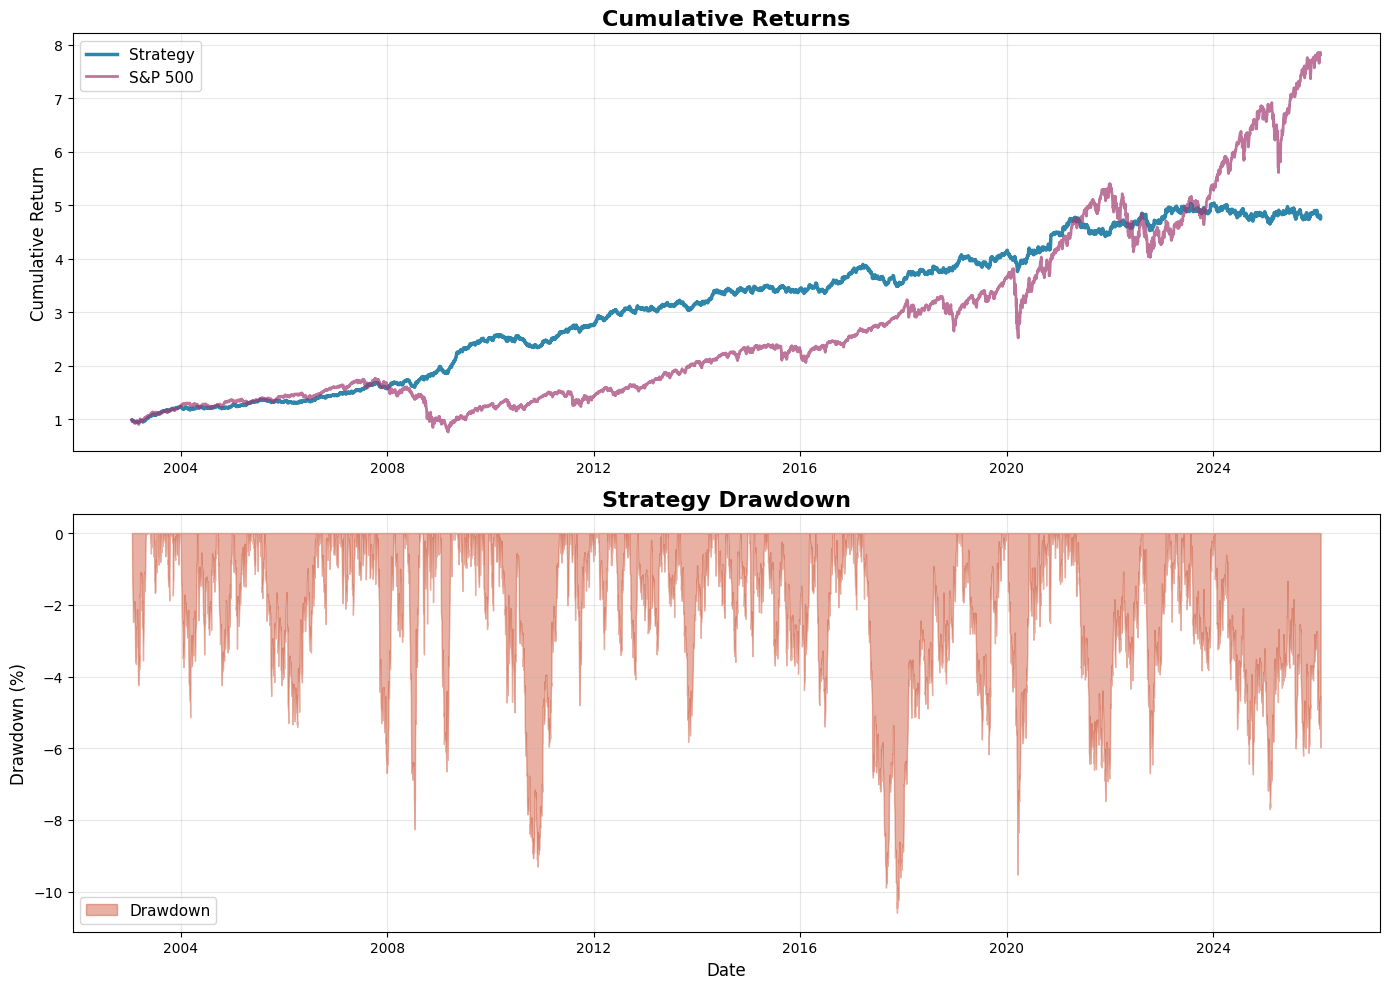


Max Drawdown: -10.59%


In [29]:
import matplotlib.pyplot as plt

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

cum_strat = (1 + strat_returns["strategy_returns"].to_numpy()).cumprod()
cum_bench = (1 + spx_aligned).cumprod()

axes[0].plot(spx_aligned.index, cum_strat, label='Strategy', linewidth=2.5, color='#2E86AB')
axes[0].plot(spx_aligned.index, cum_bench, label='S&P 500', linewidth=2, alpha=0.7, color='#A23B72')
axes[0].set_title('Cumulative Returns', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Cumulative Return', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

peak = np.maximum.accumulate(cum_strat)
dd = (cum_strat - peak) / peak

axes[1].fill_between(spx_aligned.index, 0, dd * 100, alpha=0.4, color='#C73E1D', label='Drawdown')
axes[1].set_title('Strategy Drawdown', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMax Drawdown: {dd.min()*100:.2f}%")